The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.22e-3

In [2]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [3]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [4]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [5]:
def load_exp_data(direc, cut=None, layer_size=10, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if reverse:
        file_names = [f for f in reversed(file_names)]
    if cut is not None:
        file_names = file_names[:cut]
        
    included_cell_mask = None
    file_name_count = range(0, len(file_names))
    for i_f in file_name_count:
        file = file_names[i_f]
        
        if i_f == 0:
            loaded = sio.loadmat(os.path.join(direc, file))
        
        def lazy_load():
            loaded = sio.loadmat(os.path.join(direc, file))

            summed_incoming_weights = loaded['w_r_e_summed']
            summed_incoming_weights_e_i = loaded['w_r_e_i_summed']

            try:
                exc_cells_initially_active = loaded['exc_raster']
                exc_cells_newly_active = None
            except KeyError as e:
                exc_cells_initially_active = loaded['exc_cells_initially_active'].astype(float)
                exc_cells_newly_active = loaded['exc_cells_newly_active'].astype(float)
                exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] * dt
                if exc_cells_newly_active is not None and exc_cells_newly_active.shape[0] > 0:
                    exc_cells_newly_active[0, :] = exc_cells_newly_active[0, :] * dt
            inh_raster = loaded['inh_raster']

            try:
                surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
            except KeyError as e:
                surviving_cell_indices = np.ones(summed_incoming_weights.shape[0], dtype=bool)

            summed_incoming_weights = summed_incoming_weights[(surviving_cell_indices).nonzero()[0]]

            first_spk_times = process_single_activation(exc_cells_initially_active, 800)

            last_layer_active = 0
            layer_weights = []

            for i in range(0, len(first_spk_times), layer_size):
                layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
                if layer_active:
                    last_layer_active = i/layer_size

                layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
                layer_weights.append(layer_weight)

            data = {
                'index': i_f,
                'last_layer_active': last_layer_active,
                'first_spk_times': first_spk_times,
                
                'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
                'median_incoming_summed_weights': np.median(summed_incoming_weights),
                'std_incoming_summed_weights': np.std(summed_incoming_weights),
                'summed_incoming_weights': summed_incoming_weights,
                
                'mean_incoming_summed_weights_e_i': np.mean(summed_incoming_weights_e_i),
                'median_incoming_summed_weights_e_i': np.median(summed_incoming_weights_e_i),
                'std_incoming_summed_weights_e_i': np.std(summed_incoming_weights_e_i),
                'summed_incoming_weights_e_i': summed_incoming_weights_e_i,
                
                'exc_cells_initially_active': exc_cells_initially_active,
                'exc_cells_newly_active': exc_cells_newly_active,
                'inh_raster': inh_raster,
                'freqs': loaded['freqs'][0],
                'spk_bins': loaded['spk_bins'][0],
                'surviving_cell_indices': surviving_cell_indices,
            }
            return data
        yield i_f, lazy_load

In [247]:
colors_for_trials = ['#cf496d', '#d4aa37', '#79d5a9', '#4f89af', '#20424d']

# [207, 73, 109], [243, 208, 109], [121, 213, 169] [79, 136, 175] [32, 66, 77]

In [28]:
def make_figure_1(name, timepoints = [0, 72, 73], verify_chain_timepoints=None, color='black'):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    if verify_chain_timepoints is None:
        verify_chain_timepoints = np.arange(3)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if d_idx > 3:
            continue
        print(exp_dir_name)
        scale = 1.1
           
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8 * scale, 4 * scale))
        timepoint_names = [rendition_label(t * 10) for t in timepoints]
        j = 0
        
        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):                
            if j < len(timepoints) and i == timepoints[j]:
                print(timepoints[j])
                data = load_data()
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                inh_raster = data['inh_raster']

                if j == 0:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c=color, zorder=0, alpha=0.5)
                else:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c=color, zorder=0, alpha=0.5)
                    if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0:
                        axs[j].scatter(exc_cells_newly_active[0, :] * 1000, exc_cells_newly_active[1, :], s=1, c='pink', zorder=1, alpha=1)

                if len(inh_raster) > 0:
                    axs[j].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='black', zorder=0, alpha=1)
                axs[j].set_ylim(100, 1000)
                axs[j].set_xlim(0.060 * 1000, 0.300 * 1000)
                axs[j].set_ylabel('Cell Index')
                axs[j].set_xlabel('Time (ms)')
                axs[j].title.set_text(f'{timepoint_names[j]}')
                set_font_size(axs[j], 16)
                j += 1
        
        fig.tight_layout()  
        save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')
        

In [29]:
single_ei_stdp = ['slow_stdp_drop_single']

slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--26:5107_ff_0.8_eir_2.5_ier_1.0_2021-12-07--10:58--15:5704
0
400
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--27:2567_ff_0.8_eir_2.5_ier_1.0_2021-12-09--13:14--53:5704
0
400
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--29:1235_ff_0.8_eir_2.5_ier_1.0_2021-12-09--13:16--08:5704
0
400


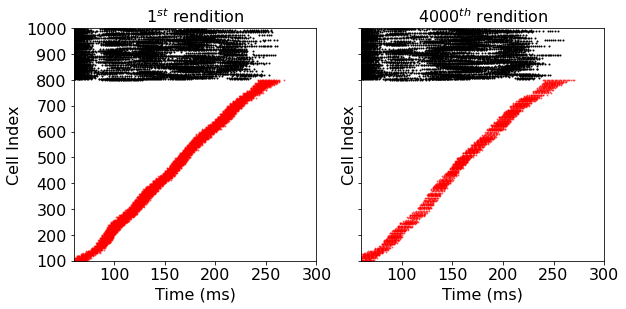

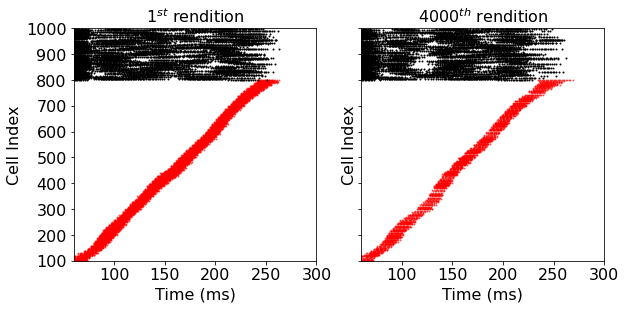

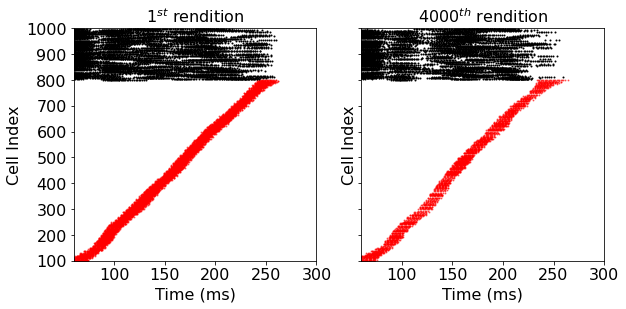

In [30]:
make_figure_1(single_ei_stdp, timepoints=[0, 400], color='red')

In [9]:
pop_ei_stdp = ['pop_slow_stdp']

pop_slow_stdp_drop_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--26:5107_ff_0.8_eir_2.5_ier_1.0_2021-12-07--10:58--18:5704
0
400


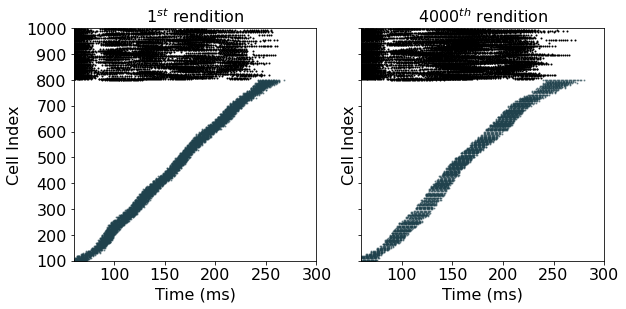

In [305]:
make_figure_1(pop_ei_stdp, timepoints=[0, 400], color=colors_for_trials[4])

In [13]:
def determine_recovered(names, timepoints, threshold=0.9):
    recovered_dir_names = []
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    all_recovery_pers = []
    all_last_layer_active_stats = []
    for i, exp_dir_names in enumerate(all_dirs):
        per_recovered_for_name = 0
        last_layer_actives_for_name = []
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            n_active = 0
            n_count = 0
            last_layer_actives = []
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                n_active += int(data['last_layer_active'] >= 79)
                last_layer_actives.append(data['last_layer_active'])
                n_count += 1
            last_layer_actives_for_name.append(np.mean(last_layer_actives))
            if n_active == 0:
                continue
            if n_active / n_count >= threshold:
                print('X')
                recovered_dir_names.append(exp_dir_name)
                per_recovered_for_name += 1
        per_recovered_for_name /= len(exp_dir_names)
        all_recovery_pers.append(per_recovered_for_name)
        mean_last_layer = np.mean(last_layer_actives_for_name)
        sem_last_layer = np.std(last_layer_actives_for_name) / np.sqrt(len(last_layer_actives_for_name))
        all_last_layer_active_stats.append((mean_last_layer, sem_last_layer))
        
    return recovered_dir_names, all_recovery_pers, all_last_layer_active_stats


In [14]:
def iter_range(r, n):
    if n == 1:
        yield (0, r[0])
    else:
        for i in range(n):
            yield (i, i * (r[1] - r[0]) / (n - 1) + r[0])

In [15]:
def real_to_str(real):
    s = f'{real}'
    first_sig_digit_idx = re.search('[1-9]', s)
    if not first_sig_digit_idx:
        return s
    
    x = s.rfind('00')
    while x >= 0 and x > first_sig_digit_idx.start():
        s = s[:x]
        x = s.rfind('00')
    return s

In [16]:
recovered_exp_names, all_recovery_pers, all_last_layer_active_stats = determine_recovered([
    single_ei_stdp,
    pop_ei_stdp,
], np.arange(350, 360))

slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--27:2567_ff_0.8_eir_2.5_ier_1.0_2021-12-09--13:14--53:5704
X
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--29:1235_ff_0.8_eir_2.5_ier_1.0_2021-12-09--13:16--08:5704
X
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--26:5107_ff_0.8_eir_2.5_ier_1.0_2021-12-07--10:58--15:5704
X
pop_slow_stdp_drop_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--26:5107_ff_0.8_eir_2.5_ier_1.0_2021-12-07--10:58--18:5704
X


In [17]:
all_recovery_pers

[1.0, 1.0]

In [128]:
# def inset_bar_plot(recovery_per, normed_final_activity_mean, normed_final_activity_mean_sem):
#     scale = 1
#     fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(3 * scale, 2.5 * scale))
#     axs2 = axs.twinx()
#     axs.bar([0], [recovery_per, normed_final_activity_mean], width=0.5)
#     axs.bar([1], [recovery_per, normed_final_activity_mean], width=0.5)
#     axs.errorbar([1], [normed_final_activity_mean], yerr=normed_final_activity_mean_sem], color='none', ecolor='black', capsize=6)
#     axs.spines['top'].set_visible(False)
#     axs2.spines['top'].set_visible(False)
#     axs.yaxis.tick_left()
#     axs2.yaxis.tick_right()
#     axs.set_xticks([0, 1])
#     axs.set_xticklabels(['Percent\nrecovered', 'Normed\nrecovered\nactivity'])

In [295]:
def inset_bar_plot(recovery_per, normed_final_activity_mean, normed_final_activity_mean_sem, color='blue'):
    scale = 1
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(3 * scale, 2.5 * scale))
    axs.bar([0, 1], [recovery_per * 100, normed_final_activity_mean * 100], width=0.5, color=color)
    axs.errorbar([1], [normed_final_activity_mean * 100], yerr=[normed_final_activity_mean_sem * 100], color='none', ecolor='black', capsize=6)
    axs.spines['top'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.set_xticks([0, 1])
    axs.set_xlim(-0.5, 1.5)
    axs.set_ylim(0, 100)
    axs.set_xticklabels(['Percent\nrecovered', 'Normalized\nrecovered\nactivity'])
    axs.yaxis.set_major_formatter(mtick.PercentFormatter())
    axs.yaxis.tick_right()
    set_font_size(axs, 14)

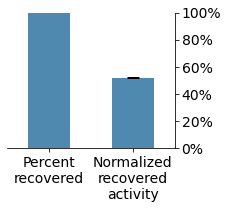

In [296]:
inset_bar_plot(1, 0.52, 0.004, color=colors_for_trials[3])

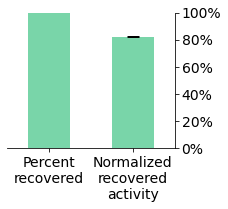

In [186]:
inset_bar_plot(1, 0.823, 0.0026, color=colors_for_trials[2])

In [18]:
def make_figure_2_plot(names, labels, condition_colors, file_name_ext='', ylim1=None, ylim2=None, ylabel1=None, ylabel2=None, cap=50, timepoints=[], offsets=[], vertical_spacing=1., axs=None, fig=None, tick_right=True, legend=True):
    
    scale = 2.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if j > 1:
                continue
            if exp_dir_name not in recovered_exp_names:
                continue
#             if j > 1:
#                 continue
            print(exp_dir_name)
            
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])
                all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == offsets[idx]:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
                
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
            all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
#             axs[0].plot(timepoints[:len(all_mean_incoming_summed_weights)] * 10, all_mean_incoming_summed_weights, color='black', lw=0.5, zorder=-1)
#             axs[1].plot(timepoints[:len(all_mean_incoming_summed_weights_e_i)] * 10, all_mean_incoming_summed_weights_e_i, color='black', lw=0.5, zorder=-1)

        
        if len(all_weights_for_dir_name) == 0:
            continue
        
        e_e_means = safe_apply_stat(all_weights_for_dir_name, np.mean)
        e_e_sems = safe_apply_stat(all_weights_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))
        e_i_means = safe_apply_stat(all_weights_e_i_for_dir_name, np.mean)
        e_i_sems = safe_apply_stat(all_weights_e_i_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx

        axs[0].fill_between(
            timepoints * 10,
            e_e_means - e_e_sems + y_disp,
            e_e_means + e_e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2)
        axs[0].plot(timepoints * 10, e_e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx])
        axs[1].fill_between(
            timepoints * 10,
            e_i_means - e_i_sems + y_disp,
            e_i_means + e_i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2)
        axs[1].plot(timepoints * 10, e_i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx])

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(0, (cap - 1) * 10)
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 16)
        
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
    if legend:
        axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')
    plt.show()

['slow_stdp_drop_single']
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--27:2567_ff_0.8_eir_2.5_ier_1.0_2021-12-09--13:14--53:5704
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--29:1235_ff_0.8_eir_2.5_ier_1.0_2021-12-09--13:16--08:5704


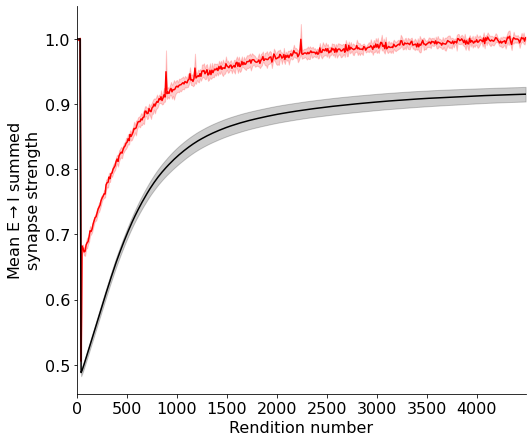

In [26]:
timepoints = np.arange(0, 450, 1)
scale = 2.5
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(3 * scale, 2.5 * scale))
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

make_figure_2_plot([
    single_ei_stdp,
], labels=[
    'projector cell firing rate homeostasis + E->I STDP',
], condition_colors=[['red', 'black']], timepoints=timepoints, cap=450, offsets=np.zeros(3), vertical_spacing=0.,
file_name_ext='all_3_silent', legend=False, tick_right=False, fig=fig, axs=[axs, axs])

['slow_stdp_drop_single']
['pop_slow_stdp']
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--27:2567_ff_0.8_eir_2.5_ier_1.0_2021-12-09--13:14--53:5704
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--29:1235_ff_0.8_eir_2.5_ier_1.0_2021-12-09--13:16--08:5704
slow_stdp_drop_single_only_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--26:5107_ff_0.8_eir_2.5_ier_1.0_2021-12-07--10:58--15:5704
pop_slow_stdp_drop_ff_0.8_eir_2.5_ier_1.0_2021-12-06--22:15--26:5107_ff_0.8_eir_2.5_ier_1.0_2021-12-07--10:58--18:5704


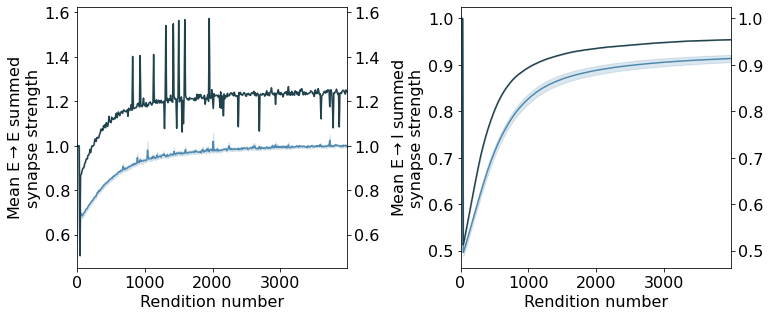

In [316]:
timepoints = np.arange(0, 450, 1)

make_figure_2_plot([
    single_ei_stdp,
    pop_ei_stdp,
], labels=[
    'projector cell firing rate homeostasis + E->I STDP',
    'projector cell firing rate homeostasis + E->I STDP + population-level firing rate homeostasis',
], condition_colors=colors_for_trials[3:], timepoints=timepoints, cap=400, offsets=np.zeros(3), vertical_spacing=0.,
file_name_ext='all_3_silent')

In [54]:
recovered_exp_names = [x.strip() for x in recovered_exp_names]


In [27]:
def extract_weight_dist_stats(names, recovered_exp_names, timepoints):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    all_weight_dist_info = []
    all_summed_weights = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        
        summed_weights_for_group = [[] for t in timepoints]
        weight_freqs_for_group = [[] for t in timepoints]
        weight_bins = [[] for t in timepoints]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            t_ctr = 0
            for k, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if k not in timepoints:
                    continue
                data = data_load()
                
                summed_incoming_weights = data['summed_incoming_weights']
                summed_weights_for_group[t_ctr].append(summed_incoming_weights)
                
                bins, freqs = bin_occurrences(summed_incoming_weights, max_val=0.0035, bin_size=0.00005)
                weight_bins[t_ctr] = bins
                weight_freqs_for_group[t_ctr].append(freqs)
                
                t_ctr += 1
        
        mean_weight_dists = []
        std_weight_dists = []
        summed_weight_bins = []
        
        mean_summed_incoming_weights = []
        std_summed_incoming_weights = []
        
        for i_t, t in enumerate(timepoints):
            mean_weight_dists.append(np.nanmean(weight_freqs_for_group[i_t], axis=0))
            std_weight_dists.append(np.nanstd(weight_freqs_for_group[i_t], axis=0))
            summed_weight_bins.append(weight_bins[i_t])
            
            mean_summed_incoming_weights.append(np.nanmean(summed_weights_for_group[i_t], axis=0).flatten())
            std_summed_incoming_weights.append(np.nanstd(summed_weights_for_group[i_t], axis=0).flatten())
                
        all_weight_dist_info.append({
            'mean_weight_dists': mean_weight_dists,
            'std_weight_dists': std_weight_dists,
            'summed_weight_bins': summed_weight_bins[0][0],
            'mean_summed_incoming_weights': mean_summed_incoming_weights,
            'std_summed_incoming_weights': std_summed_incoming_weights,
        })
    return all_weight_dist_info

In [28]:
all_weight_dist_info = extract_weight_dist_stats([
    fr_only_name_frags,
    two_single_cell_rules_name_frags,
    pop_name_frags
], recovered_exp_names, [0, 10, 50])

single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2085_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--21:15--10:0323
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2088_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--21:15--10:7256
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2081_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--03:11--15:7624
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2089_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--21:15--10:2764
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2062_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:2403
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2063_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-07--22:22--34:0508
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2083_ALPHA_2_0_ALPHA_1_0.006_ff_0.7_eir_0.5_ier_0.0_2021-12-08--03:11--15:5917
single_silent_only__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED

pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2072_ALPHA_2_0.0005_ALPHA_1_0.006_GAMMA_1e-05_ff_0.7_eir_0.5_ier_0.0_2021-12-09--00:09--32:5866
pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2061_ALPHA_2_0.0005_ALPHA_1_0.006_GAMMA_1e-05_ff_0.7_eir_0.5_ier_0.0_2021-12-09--00:09--32:7565
pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2073_ALPHA_2_0.0005_ALPHA_1_0.006_GAMMA_1e-05_ff_0.7_eir_0.5_ier_0.0_2021-12-09--00:09--32:5149
pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2066_ALPHA_2_0.0005_ALPHA_1_0.006_GAMMA_1e-05_ff_0.7_eir_0.5_ier_0.0_2021-12-09--00:09--32:1561
pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2077_ALPHA_2_0.0005_ALPHA_1_0.006_GAMMA_1e-05_ff_0.7_eir_0.5_ier_0.0_2021-12-09--00:09--32:5117
pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SEED_2069_ALPHA_2_0.0005_ALPHA_1_0.006_GAMMA_1e-05_ff_0.7_eir_0.5_ier_0.0_2021-12-09--00:09--32:7542
pop_single_small_silent__SYN_PROP_DIST_1.3_DROP_SEV_0.5_SE

In [29]:
pickle.dump(all_weight_dist_info, open('parsed_data_3.p', 'wb'))


In [104]:
# aggregate_weight_dist_data = pickle.load(open('./parsed_data_3.p', 'rb'))
# print(aggregate_weight_dist_data)

(0.0, 0.0009)

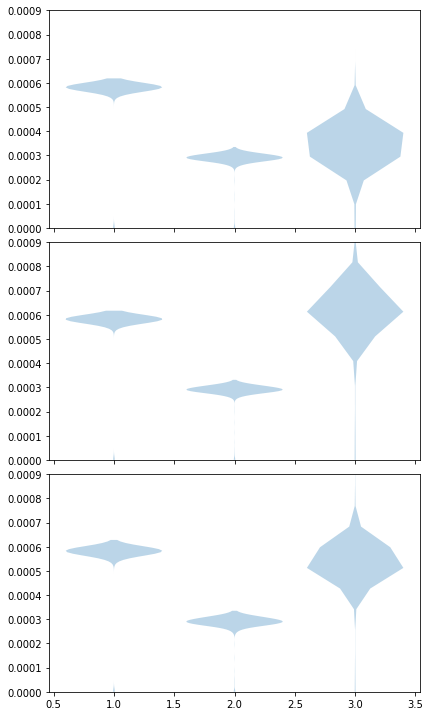

In [30]:
scale = 1
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6 * scale, 10 * scale))

for k, dist_data_for_name in enumerate(all_weight_dist_info):
    if len(dist_data_for_name) > 0:
        ax = axs[k]
        ax.violinplot(dist_data_for_name['mean_summed_incoming_weights'], showmeans=False, showextrema=False, widths=0.8 * np.ones(3))
#         for i_t, dist_data_for_tp in enumerate(dist_data_for_name):
            
#             ax.fill_between(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_initial'] - dist_data['std_weight_dists_initial'], dist_data['mean_weight_dists_initial'] + dist_data['std_weight_dists_initial'], color='black', alpha=0.2)
#             ax.plot(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_initial'], color='black')
#             ax.fill_between(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_final'] - dist_data['std_weight_dists_final'], dist_data['mean_weight_dists_final'] + dist_data['std_weight_dists_final'], color='red', alpha=0.2)
#             ax.plot(dist_data['summed_weight_bins'], dist_data['mean_weight_dists_final'], color='red')
fig.tight_layout()
ax.set_ylim(0, 0.0009)

In [71]:
# def make_figure_3(names, ylim=(0, 8), trials=[3], timepoints = [0, 10, 12, 299], spaced_colors=['#ff1717', '#d117ff', '#171bff']):    
#     all_dirs = []
#     for name in names:
#         if type(name) is list:
#             all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
#         else:
#             all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
            
#     labels = [
#         'unperturbed',
#         '130th rendition',
#         '500th rendition',
#     ]
    
#     for i_t in trials:
#         scale = 1.1
#         fig = plt.figure(constrained_layout=True, figsize=(25 * scale, 10 * scale))
#         gs = gridspec.GridSpec(ncols=18, nrows=6, figure=fig)
       
#         def create_split_freq_plot(row_start, row_end, col_start, fig, gs):
#             sub_axs = [
#                 fig.add_subplot(gs[row_start:row_end, col_start]),
#                 fig.add_subplot(gs[row_start:row_end, (col_start+1):(col_start+6)])
#             ]
#             sub_axs[1].yaxis.tick_right()
#             sub_axs[0].tick_params(bottom=False, labelbottom=False)
#             sub_axs[0].set_ylabel('Number neurons')
#             sub_axs[0].set_xlim(-1.5, 1.5)
#             sub_axs[1].set_xlim(0.5, 45)
#             sub_axs[0].set_ylim(0, 1000)
#             sub_axs[1].set_ylim(0, 1000)
#             sub_axs[0].set_xlabel('Silent')
#             sub_axs[0].spines['right'].set_visible(False)
#             sub_axs[0].spines['top'].set_visible(False)
#             sub_axs[1].spines['left'].set_visible(False)
#             sub_axs[1].spines['top'].set_visible(False)
#             return sub_axs
            

#         col_1_axs = [create_split_freq_plot(i, i+2, 6, fig, gs) for i in range(0, 6, 2)]
#         col_2_axs = [create_split_freq_plot(i, i+2, 12, fig, gs) for i in range(0, 6, 2)]
        
#         axs = [
#             [create_split_freq_plot(0, 6, 0, fig, gs)],
#             col_1_axs,
#             col_2_axs,
#         ]
        
#         spk_bins_zero = None
#         freqs_zero = None
#         spk_bins_i_zero = None
#         freqs_i_zero = None
        
#         for idx, exp_dir_names in enumerate(all_dirs):
#             j = 0
#             exp_dir_names = sorted(exp_dir_names, key=lambda x: x[-4:])
#             for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_names[i_t]), name_frags=['dropout_0']):
#                 if j < len(timepoints) and i == timepoints[j]:
#                     data = data_load()
 
#                     if j >= 1:
#                         if idx == 0:
#                             axs[j][idx][0].bar(spk_bins_zero[:1], freqs_zero[:1], color='gray', alpha=0.2, zorder=-j, width=1, label=labels[0])
#                             axs[j][idx][1].plot(spk_bins_zero[1:], freqs_zero[1:], color='gray', alpha=1., zorder=-j, lw=2.5, label=labels[0])
                            
#                             axs[j][idx][1].plot(spk_bins_i_zero, freqs_i_zero, '--', color='gray', alpha=1., zorder=-j, lw=2.5, label=labels[0] + ' inh')
#                         else:
#                             axs[j][idx][0].bar(spk_bins_zero[:1], freqs_zero[:1], color='gray', alpha=0.2, zorder=-j, width=1)
#                             axs[j][idx][1].plot(spk_bins_zero[1:], freqs_zero[1:], color='gray', alpha=1., zorder=-j, lw=2.5)
                            
#                             axs[j][idx][1].plot(spk_bins_i_zero, freqs_i_zero, '--', color='gray', alpha=1., zorder=-j, lw=2.5)

#                     spk_bins = data['spk_bins']
#                     freqs = data['freqs']
#                     spks_for_i_cells = data['inh_raster']
#                     if len(spks_for_i_cells) > 0:
#                         spks_for_i_cells = spks_for_i_cells[1]
#                         cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=2000, max_val=3000, bin_size=1)
#                         spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
#                     else:
#                         spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                    
#                     if j == 0:
#                         spk_bins_zero = spk_bins
#                         freqs_zero = freqs
#                         spk_bins_i_zero = spk_bins_i
#                         freqs_i_zero = freqs_i

#                     if j >= 1 or (j == 0 and idx == 0):
#                         color = 'black' if j < 1 else spaced_colors[idx]
#                         if idx == 0:
#                             axs[j][idx][0].bar(spk_bins[:1], freqs[:1], color=color, alpha=0.7, zorder=-j, width=1, label=labels[j])
#                             axs[j][idx][1].plot(spk_bins[1:], freqs[1:], color=color, alpha=1., zorder=-j, lw=2.5, label=labels[j])
                            
#                             axs[j][idx][1].plot(spk_bins_i, freqs_i, '--', color=color, alpha=1., zorder=-j, lw=2.5, label=labels[j] + ' inh')
#                         else:
#                             axs[j][idx][0].bar(spk_bins[:1], freqs[:1], color=color, alpha=0.7, zorder=-j, width=1)
#                             axs[j][idx][1].plot(spk_bins[1:], freqs[1:], color=color, alpha=1., zorder=-j, lw=2.5)
                            
#                             axs[j][idx][1].plot(spk_bins_i, freqs_i, '--', color=color, alpha=1., zorder=-j, lw=2.5)
            
#                         if idx == (len(all_dirs) - 1):
#                             axs[j][idx][1].set_xlabel('Spikes per neuron')
                        
#                         if idx == 0:
#                             axs[j][idx][1].legend(frameon=False)
                    
#                         set_font_size(axs[j][idx][0], 18)
#                         set_font_size(axs[j][idx][1], 18)

#                     j += 1
                    
#         axs[0][0][0].set_ylim(0, 1000)
#         axs[0][0][1].set_xlabel('Spikes per neuron')
#         plt.locator_params(axis='x', nbins=5)
#         save_fig(fig, './figures/paper/fig_3', f'trial_{i_t}.png')

In [281]:
def make_figure_3(names, ylim=(0, 8), trials=[3], timepoints = [0, 10, 12, 299], color='blue'):    
    all_dirs = []
    for name in names:
        if type(name) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
            
    labels = [
        'unperturbed',
        '900th rendition',
    ]
    
    for i_t in trials:
        scale = 1.1
        fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6 * scale, 3 * scale))
        axs2 = axs.twinx()
        spk_bins_zero = None
        freqs_zero = None
        spk_bins_i_zero = None
        freqs_i_zero = None
        
        for idx, exp_dir_names in enumerate(all_dirs):
            j = 0
            exp_dir_names = sorted(exp_dir_names, key=lambda x: x[-4:])
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_names[i_t]), name_frags=['dropout_0']):
                if j < len(timepoints) and i == timepoints[j]:
                    data = data_load()
 

                    spk_bins = data['spk_bins']
                    freqs = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=800, max_val=1000, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                        
                    if j >= 1:
                        axs.plot(spk_bins_zero, freqs_zero, color='gray', alpha=1., zorder=-j, lw=2.5, label=labels[0])
                        axs2.plot(spk_bins_i_zero, freqs_i_zero, '--', color='gray', alpha=1., zorder=-j, lw=2.5, label=labels[0] + ' inh')

                        axs.plot(spk_bins, freqs, color=color, alpha=1., zorder=-j, lw=2.5, label=labels[j]) 
                        axs2.plot(spk_bins_i, freqs_i, '--', color=color, alpha=1., zorder=-j, lw=2.5, label=labels[j] + ' inh')
                    
                    if j == 0:
                        spk_bins_zero = spk_bins
                        freqs_zero = freqs
                        spk_bins_i_zero = spk_bins_i
                        freqs_i_zero = freqs_i

                    axs.set_xlabel('Spikes per neuron')
                    axs.set_ylabel('Excitatory counts')
                    axs2.set_ylabel('Inhibitory counts')
                    axs.set_xlim(0, 50)
                        
                    axs.legend(frameon=False)
                    
                    set_font_size(axs, 15)
                    set_font_size(axs2, 15)

                    j += 1
                    
        plt.locator_params(axis='x', nbins=5)

## Figure 3: comparisons of the firing rate distributions of HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

### First run only

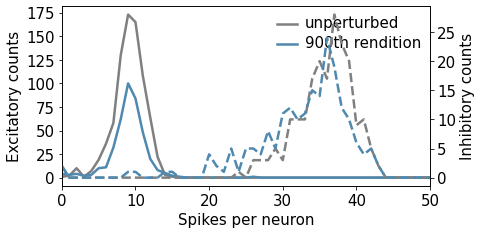

In [322]:
make_figure_3([
    single_ei_stdp,
], timepoints=[0, 400], trials=np.arange(1), color=colors_for_trials[3])

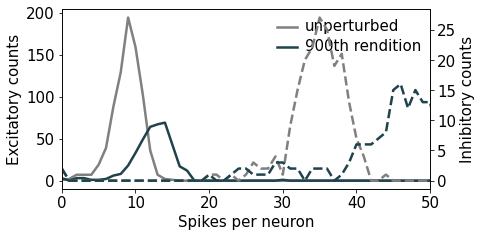

In [323]:
make_figure_3([
    pop_ei_stdp,
], timepoints=[0, 400], trials=np.arange(1), color=colors_for_trials[4])

(1) BTDP + single-cell firing rate upper bound + popopulation-level firing rate

(2) BTDP + population-level firing rate

(3) BTDP + single-cell rule (NOTE: single cell setpoints were artificial & silent cells were drawn in early)

In [35]:
def make_figure_3b(name, ylim=(0, 8), initial_timepoint_range=(0, 4), final_timepoint_range=(90, 94), color='blue'):    
    all_dirs = [dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)]
            
    labels = [
        'unperturbed',
        '900th rendition',
    ]
    
    scale = 1.9
    fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(3 * scale, 3 * scale))
    axs2 = axs.twinx()
    
    firing_rate_stats_initial = {
        'spk_bins_e': None,
        'freqs_e': [],
        'spk_bins_i': None,
        'freqs_i': [],
    }
    firing_rate_stats_final = copy(firing_rate_stats_initial)
           
    for idx, exp_dir_name in enumerate(all_dirs):
        for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name)):
            if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]) or (i >= final_timepoint_range[0] and i <= final_timepoint_range[1]):
                    data = data_load()

                    spk_bins_e = data['spk_bins']
                    freqs_e = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=800, max_val=1000, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                        
                    if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]):
                        firing_rate_stats = firing_rate_stats_initial
                    else:
                        firing_rate_stats = firing_rate_stats_final
                        
                    if firing_rate_stats['spk_bins_e'] is None:
                        firing_rate_stats['spk_bins_e'] = spk_bins_e
                    if firing_rate_stats['spk_bins_i'] is None:
                        firing_rate_stats['spk_bins_i'] = spk_bins_i
                    firing_rate_stats['freqs_e'].append(freqs_e)
                    firing_rate_stats['freqs_i'].append(freqs_i)
        
    for firing_rate_stats in [firing_rate_stats_initial, firing_rate_stats_final]:
        firing_rate_stats['freqs_e'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0), np.std(np.stack(firing_rate_stats['freqs_e']), axis=0))
        firing_rate_stats['freqs_i'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0), np.std(np.stack(firing_rate_stats['freqs_i']), axis=0))

    freqs_e_initial_low = firing_rate_stats_initial['freqs_e'][0] - firing_rate_stats_initial['freqs_e'][1]
    freqs_e_initial_high = firing_rate_stats_initial['freqs_e'][0] + firing_rate_stats_initial['freqs_e'][1]
    axs.fill_between(firing_rate_stats_initial['spk_bins_e'], y1=freqs_e_initial_low, y2=freqs_e_initial_high, color='gray', alpha=0.2, zorder=-1)
    axs.plot(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], color='gray', alpha=1., zorder=-1, lw=1.2, label=labels[0])
    
    freqs_i_initial_low = firing_rate_stats_initial['freqs_i'][0] - firing_rate_stats_initial['freqs_i'][1]
    freqs_i_initial_high = firing_rate_stats_initial['freqs_i'][0] + firing_rate_stats_initial['freqs_i'][1]
    axs2.fill_between(firing_rate_stats_initial['spk_bins_i'], y1=freqs_i_initial_low, y2=freqs_i_initial_high, color='gray', alpha=0.2, zorder=-1)
    axs2.plot(firing_rate_stats_initial['spk_bins_i'], firing_rate_stats_initial['freqs_i'][0], '--', color='gray', alpha=1., zorder=-1, lw=1.2, label=labels[0] + ' inh')

    freqs_e_final_low = firing_rate_stats_final['freqs_e'][0] - firing_rate_stats_final['freqs_e'][1]
    freqs_e_final_high = firing_rate_stats_final['freqs_e'][0] + firing_rate_stats_final['freqs_e'][1]
    axs.fill_between(firing_rate_stats_final['spk_bins_e'], y1=freqs_e_final_low, y2=freqs_e_final_high, color='red', alpha=0.2, zorder=-1)
    axs.plot(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], color='red', alpha=1., zorder=0, lw=1.2, label=labels[1]) 
    
    freqs_i_final_low = firing_rate_stats_final['freqs_i'][0] - firing_rate_stats_final['freqs_i'][1]
    freqs_i_final_high = firing_rate_stats_final['freqs_i'][0] + firing_rate_stats_final['freqs_i'][1]
    axs2.fill_between(firing_rate_stats_final['spk_bins_i'], y1=freqs_i_final_low, y2=freqs_i_final_high, color='red', alpha=0.2, zorder=-1)
    axs2.plot(firing_rate_stats_final['spk_bins_i'], firing_rate_stats_final['freqs_i'][0], '--', color='red', alpha=1., zorder=0, lw=1.2, label=labels[1] + ' inh')

    axs.set_xlabel('Spikes per rendition')
    axs.set_ylabel('Excitatory counts')
    axs2.set_ylabel('Inhibitory counts')
    axs.set_xlim(0, 50)
    axs.spines['top'].set_visible(False)
    axs2.spines['top'].set_visible(False)
    axs.set_ylim(0, 175)
    axs2.set_ylim(0)

    axs.legend(frameon=False)

    set_font_size(axs, 15)
    set_font_size(axs2, 15)

    plt.locator_params(axis='x', nbins=5)

In [36]:
def make_figure_4_averaged(names, labels, spaced_colors, dropout=0, file_name_ext='', ylim=(0, 8), cap=100):
    scale = 1.4
    fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10 * scale, 7.5 * scale))
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    all_dirs = []
    for name in names:
        if type(name) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])

    x = np.concatenate([np.ones(10) * (i/10) for i in range(0, 800, 10)])
    
    for idx, exp_dir_names in enumerate(all_dirs):
        to_plot = ['pop_firing_rates', 'inh_pop_firing_rates', 'relative_prop_speeds', 'r_squareds', 'last_layer_actives']
        
        plot_data = {}
        for var in to_plot:
            plot_data[var] = {'raw': []}
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            
            for var in to_plot:
                plot_data[var]['raw'].append([])

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[f'dropout_{dropout}']):
                if i == cap:
                    break
                data = load_data()

                pop_firing_rate = np.sum(data['exc_cells_initially_active'])
                if data['exc_cells_newly_active'] is not None:
                    pop_firing_rate += np.sum(data['exc_cells_newly_active'])
                plot_data['pop_firing_rates']['raw'][-1].append(pop_firing_rate)
                
                inh_pop_firing_rate = np.sum(data['inh_raster'])
                plot_data['inh_pop_firing_rates']['raw'][-1].append(inh_pop_firing_rate)

                first_spk_times = data['first_spk_times']
                filtered_indices = data['surviving_cell_indices'] & (~np.isnan(first_spk_times))

                x_firing = x[filtered_indices]
                first_spk_times_nonnan = first_spk_times[filtered_indices]

                res = stats.linregress(first_spk_times_nonnan, x_firing)
                plot_data['relative_prop_speeds']['raw'][-1].append(res.slope)
                plot_data['r_squareds']['raw'][-1].append(np.square(res.rvalue))
                plot_data['last_layer_actives']['raw'][-1].append(data['last_layer_active'])
                
        for var in to_plot:
            plot_data[var]['means'] = safe_apply_stat(plot_data[var]['raw'], np.mean)
            plot_data[var]['stds'] = safe_apply_stat(plot_data[var]['raw'], np.std)
            plot_data[var]['sems'] = safe_apply_stat(plot_data[var]['raw'], lambda x: np.std(x) / np.sqrt(len(x)))
            
        epochs = np.arange(0, cap * 10, 10)
        
        axs[0, idx].fill_between(
            epochs,
            plot_data['pop_firing_rates']['means'] - plot_data['pop_firing_rates']['sems'],
            plot_data['pop_firing_rates']['means'] + plot_data['pop_firing_rates']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[0, idx].plot(epochs, plot_data['pop_firing_rates']['means'], c=spaced_colors[idx], lw=1., label=labels[idx])
        print(plot_data['pop_firing_rates']['means'], plot_data['pop_firing_rates']['sems'])
#         axs[0, idx].fill_between(
#             epochs,
#             plot_data['inh_pop_firing_rates']['means'] - plot_data['inh_pop_firing_rates']['sems'],
#             plot_data['inh_pop_firing_rates']['means'] + plot_data['inh_pop_firing_rates']['sems'],
#             color=spaced_colors[idx], alpha=0.15
#         )
#         line, = axs[0, idx].plot(epochs, plot_data['inh_pop_firing_rates']['means'], '-', c=spaced_colors[idx], lw=1., label=f'{labels[idx]} inh', )
#         line.set_dashes([4, 4])
        axs[1, idx].fill_between(
            epochs,
            plot_data['relative_prop_speeds']['means'] - plot_data['relative_prop_speeds']['sems'],
            plot_data['relative_prop_speeds']['means'] + plot_data['relative_prop_speeds']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[1, idx].plot(epochs, plot_data['relative_prop_speeds']['means'], c=spaced_colors[idx], lw=1.)
        axs[2, idx].fill_between(
            epochs,
            plot_data['r_squareds']['means'] - plot_data['r_squareds']['sems'],
            plot_data['r_squareds']['means'] + plot_data['r_squareds']['sems'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[2, idx].plot(epochs, plot_data['r_squareds']['means'],c=spaced_colors[idx], lw=1.)
#         axs[0, idx].set_ylim(0, 8e7)
#         axs[1, idx].set_ylim(250, 500)
#         axs[2, idx].set_ylim(0.6, 1.05)
        
    axs[0, 0].set_ylabel('Total excitatory activity')
    axs[1, 0].set_ylabel('Propagation speed (layers/s)')
    axs[2, 0].set_ylabel(r'$R^2$')
    
    axs[0, 2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    for i in range(3):
        for j in range(3):
            axs[i, j].set_xlim(0, cap * 10)
            axs[i, 0].set_xlabel('Rendition number\n\n')
            set_font_size(axs[i, j], 16)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.22, wspace=0.35)
    save_fig(fig, './figures/paper/fig_4', f'population_activity_+_prop_speed_{file_name_ext}.png')

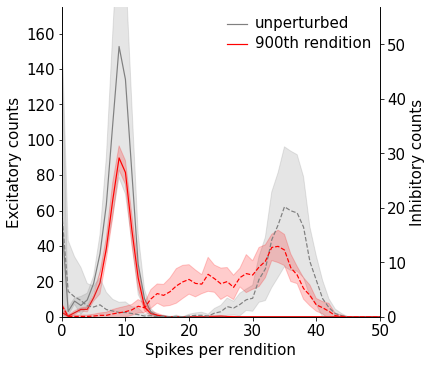

In [37]:
make_figure_3b(single_ei_stdp, color='red')

## Figure 4: metrics of dynamics

### 50% dropout of HVC(RA) projectors

[2924875.10656667 2887971.55292    2882656.99809333 2927177.33984667
  103285.08724667 1465428.40552    1465725.57542    1476071.92511333
 1466934.90974667 1483737.5724     1453247.28643333 1476733.76790667
 1476688.07123333 1506032.78114667 1469761.29924    1466698.34617333
 1459087.14964667 1508946.58578667 1500014.71692667 1476425.63836667
 1489487.59996    1463609.01268    1475041.68434667 1442270.19156667
 1472820.50882    1460598.2734     1474863.27014667 1471997.91235333
 1475167.60284667 1519141.90018667 1475881.79510667 1466882.30682667
 1507088.95508    1454833.3266     1500774.13671333 1461502.35912667
 1507046.39586667 1468557.46645333 1449847.76152    1480448.07852667
 1471748.26506667 1485579.2244     1510749.86502    1491086.37738667
 1472742.74085333 1459643.239      1487591.25673333 1456299.00176
 1493404.06715333 1491339.72648    1497642.38112667 1463260.67743333
 1456814.31880667 1454902.68742667 1484449.60184667 1474420.18412667
 1471101.6336     1431940.14550667 14

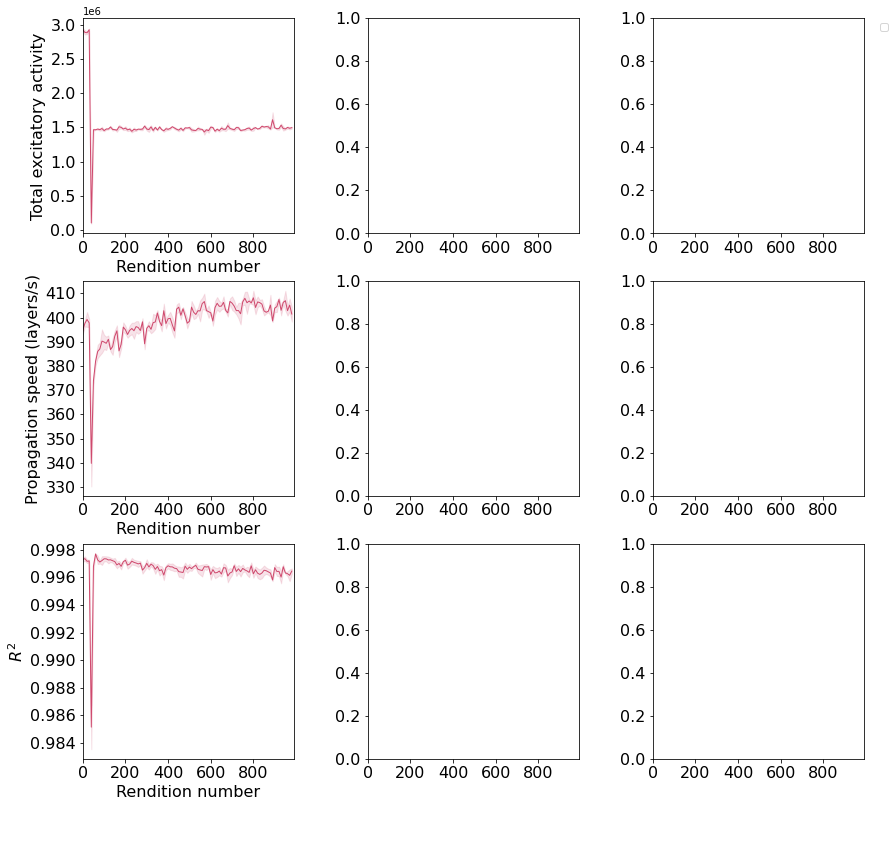

In [292]:
make_figure_4_averaged([
    single_ei_stdp
], [
    'projector cell firing rate homeostasis + E->I STDP'
], colors_for_trials[:3], file_name_ext='both_rules', cap=99)

In [148]:
1496168.09621333 / 2924875.10656667

0.5218825260050549

In [293]:
13525.60686279 / 2924875.10656667

0.004624336551131195